# Introduction to NLP FUndamentals in TensorFlow

NLP has the goal of deriving information out of naturallanguage (could be text or speech).

Another common term for NLP problms is sequence to sequence problems (seq2seq)

## Check for GPU

In [1]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



## Get helper functions

In [2]:
!wget http://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import series of helper functions for the notebook
from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys

--2023-03-10 19:48:54--  http://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py [following]
--2023-03-10 19:48:54--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-03-10 19:48:54 (67.2 MB/s) - ‘helper_

## Get a text dataset

The dataset we're going to be using is Kaggle's introduction to NLP dataset (text samples of Tweets labelled as diaster or not disaster).

See the original source here: https://www.kaggle.com/c/nlp-getting-started

In [3]:
!wget https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip

# Unzip data
unzip_data("nlp_getting_started.zip")

--2023-03-10 19:49:03--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.141.128, 74.125.137.128, 142.251.2.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.141.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.007s  

2023-03-10 19:49:03 (78.0 MB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



## Visualizing a text dataset

To visualize our text samples, we first have to read them in, one wat ro do so would be to use Python: https://realpython.com/read-write-files-python/

But I prefer to get visual straight away.

So another way to do this is to use pandas

In [4]:
import pandas as pd
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
# Shuffle training dataframe
train_df_shuffled = train_df.sample(frac=1, random_state=42)
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [6]:
# What does the test dataframe look like?
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [7]:
# How many examples of each class?
train_df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [8]:
# How many total samples?
len(train_df), len(test_df)

(7613, 3263)

In [9]:
from pandas.core.window.rolling import ResamplerWindowApply
# Let's visualize some random trining examples
import random
random_index = random.randint(0, len(train_df)-5) # create random indexes not higher than the total number of samples
for row in train_df_shuffled[["text", "target"]][random_index:random_index+5].itertuples():
  _, text, target = row
  print(f"Target: {target}", "(real disaster)" if target > 0 else "(not real disaster)")
  print(f"Text:\n{text}\n")
  print("---\n")

Target: 1 (real disaster)
Text:
Families to sue over Legionnaires: More than 40 families affected by the fatal outbreak of Legionnaires' disea... http://t.co/02ELqLOpFk

---

Target: 0 (not real disaster)
Text:
@justinbieber @ArianaGrande SCREAMING

---

Target: 1 (real disaster)
Text:
#Russian food crematoria provokes outrage amid crisis famine memories http://t.co/FjeaFgbZfJ

---

Target: 0 (not real disaster)
Text:
@Bang_Me_Up_Guk he was ;-; like he was singing so loud ;-;

---

Target: 1 (real disaster)
Text:
Families to sue over Legionnaires: More than 40 families affected by the fatal outbreak of Legionnaires' disea... http://t.co/oJyW7jkUH5

---



### Split data into training and validation sets

Test dataset does not have label for us to evaluate.  We need to split trainind data into training and validation set

In [10]:
from sklearn.model_selection import train_test_split


In [11]:
# Use train_test_split to split training data into training and validation sets
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled["text"].to_numpy(),
                                                                            train_df_shuffled["target"].to_numpy(),
                                                                            test_size=0.1,
                                                                            random_state=42)

In [12]:
# Check the lengths
len(train_sentences), len(train_labels), len(val_sentences), len(val_labels)

(6851, 6851, 762, 762)

In [13]:
# Check the first 10 samples
train_sentences[:10], train_labels[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object), array([0, 

## Converting text into numbers

When dealing with a text problem, one of the first things you'll have to do before you can build a model is to convert your text to numbers.

There are a few ways to do this, namely:
* Tokenization - direct mapping of token (a token could be a word or a cheacter) to number
* Embedding - create a matrix of feature vector for each token (the size of the feature vector can be defined and this embedding can be learned)

### Text vectorization (tokenization)

In [14]:
train_sentences[:5]

array(['@mogacola @zamtriossu i screamed after hitting tweet',
       'Imagine getting flattened by Kurt Zouma',
       '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
       "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
       'Somehow find you and I collide http://t.co/Ee8RpOahPk'],
      dtype=object)

In [15]:
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

# Use the default TextVectorization parameters
text_vectorizer = TextVectorization(max_tokens=None, # how many words in the vocabulary (automatically add <OOV>)
                                    standardize="lower_and_strip_punctuation",
                                    split="whitespace",
                                    ngrams=None, # create groups of n-words?
                                    output_mode="int", # how to map tokens to numbers
                                    output_sequence_length=None, # how long do you want your sequences to be
                                    pad_to_max_tokens=False)

In [16]:
# Find the average number of tokens (words) in the training tweets
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

15

In [17]:
# Setup text vectorization variables
max_vocab_length = 10000 # max number of words to have in our vocabulary
max_length = 15  # max length our sequences will be (e.g. how many words from a Tweet does a model see?)

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                       output_mode="int",
                                       output_sequence_length=max_length)


In [18]:
# Fit the text vectorizer to the training text
text_vectorizer.adapt(train_sentences)

In [19]:
# Create a sample sentence and tokenize it
sample_sentence = "There's a flood in my street!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[264,   3, 232,   4,  13, 698,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In [20]:
# Choose a ranodm sentence from the training dataset and tokenize it
random_sentence = random.choice(train_sentences)
print(f"Orginial text:\n {random_sentence}\
        \n\nVectorized version:")
text_vectorizer([random_sentence])

Orginial text:
 Survival Kit Whistle Fire Starter Wire Saw Cree Torch Emergency Blanket S knife  - Full reÛ_ http://t.co/cm7HqwWUlZ http://t.co/KdwAzHQTov        

Vectorized version:


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[1754, 1395, 4257,   42, 2679, 2603,  414, 1090, 3317,   73, 4085,
         236, 5267,  120,  644]])>

In [21]:
# Get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary() # get all of the unique words in our training data
top_5_words = words_in_vocab[:5] # get the most common words
bottom_5_words = words_in_vocab[-5:] # get the least common words
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"5 most common words: {top_5_words}")
print(f"5 least common words: {bottom_5_words}")

Number of words in vocab: 10000
5 most common words: ['', '[UNK]', 'the', 'a', 'in']
5 least common words: ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


###Creating an Embedding using an Embedding layer

To make our embedding, we're going to use TensorFlow's embedding layer: https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding

The parameters we care most about for our embedding layer:
* `input_dim` = the size of our vocabulary
* `output_dim` = the size of the output embedding vector, for example, a value of 100 would mean each token gets represented by a vector 100 long
* `input_length` = length of the sequences being passed to the embedding layer

In [22]:
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim=max_vocab_length, # set input shape
                             output_dim=128, # output shape
                             input_length=max_length # how long is each input
                             )
embedding


In [23]:
# Get a random sentence from the training set
random_sentence = random.choice(train_sentences)
print(f"Original text:\n {random_sentence}\
        \n\nEmbedded version:")

# Embed the random sentence (turn it into dense vectors of fixed size)
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed


Original text:
 @OllyMursAus I do feel sorry for him! He is not a piece of meat! He is a nice guy... People don't need to rush him and screams in his face!        

Embedded version:


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[-0.01294041, -0.04807782,  0.00429076, ..., -0.02160206,
          0.02920767, -0.02911087],
        [-0.02798103,  0.03311301, -0.03762675, ...,  0.00263242,
         -0.04449247, -0.02960852],
        [-0.00197482,  0.01405105,  0.03609319, ..., -0.03118685,
         -0.0283092 , -0.04034457],
        ...,
        [ 0.01470566, -0.02476941, -0.0215376 , ...,  0.03569258,
         -0.01658547,  0.02164299],
        [ 0.04893932,  0.01286024,  0.02522937, ...,  0.04329851,
         -0.02379814, -0.02246784],
        [-0.00071014,  0.04965996, -0.03057557, ..., -0.00604301,
          0.02928283,  0.01992703]]], dtype=float32)>

In [24]:
# Check out a single token's embedding
sample_embed[0][0], sample_embed[0][0].shape, random_sentence[0]

(<tf.Tensor: shape=(128,), dtype=float32, numpy=
 array([-0.01294041, -0.04807782,  0.00429076,  0.02899403,  0.0088741 ,
         0.00263717, -0.04583175,  0.01979313, -0.04594777, -0.01398131,
         0.02391154, -0.02732444, -0.0069971 ,  0.03641707, -0.03905509,
         0.01972219,  0.01630673,  0.03260131, -0.04235287, -0.02801818,
         0.03637624, -0.02340562,  0.04006344,  0.04054422, -0.02882215,
         0.04394189, -0.01765589,  0.0388347 , -0.02513644,  0.0118067 ,
        -0.00653058, -0.02374824, -0.02573515, -0.00368854, -0.01923018,
        -0.00304379, -0.03633658, -0.04414011, -0.01900711, -0.02167203,
         0.04198568,  0.02151481, -0.00130035, -0.04568062,  0.04682601,
         0.03215832,  0.02991321, -0.04442079, -0.03631442,  0.03288927,
         0.03648646,  0.01617218, -0.03756249, -0.02389335,  0.00096524,
        -0.03662398,  0.04127337,  0.03925171,  0.00695106, -0.01151167,
        -0.01832658,  0.02925741,  0.01136936,  0.037272  ,  0.0351594 ,
  

## Modelling a text dataset (running a series of experiments)

Now we've got a way to turn our text sequences into numbers, it's time to start building a series of modelling experiments.

We'll start with a baseline and move on from there.

* Model 0: Naive Bayes (baseline), this is from Sklearn ML map: https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html
* Model 1: Feed-forward neural network (dense model)
* Model 2: LSTM model (RNN)
* Model 3: GRU model (RNN)
* Model 4: Bidrectional-LSTM model (RNN)
* Model 5: 1D Convolutional Neural Network (CNN)
* Model 6: TensorFlow Hub Pretrained Feature Extractor (using transfer learning for NLP)
* Model 7: Same as model 6 with 10% of training data.

How are we going to approach all of these?

Use the standard steps in modelling with tensorflow:
* Create a model
* Build a model
* Fit a model
* Evaluate our model


### Model 0: Getting a baseline

As with all machine learning modelling experiments, it's important to create a baseline model so you've got a benchmark for future experiments to build upon.

To create our baseline, we'll use Sklearn's Multinomial Naive Bayes using the TF-IDF formula to convert our words to numbers.

**Note:** It's common practice to use non-DL algorithms as a baseline because of their speed and then later using DL to see if you can improve upon them.

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization and modelling pipeline
model_0 = Pipeline([
                    ("tfidf", TfidfVectorizer()), # convert words to numbers using tfidf
                    ("clf", MultinomialNB()) # model the text
])

# Fit the pipeline to the training data
model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [26]:
# Evaluate our baseline model
baseline_score = model_0.score(val_sentences, val_labels)
print(f"Our baseline model achieves an accuracy of: {baseline_score*100:.2f}%")

Our baseline model achieves an accuracy of: 79.27%


In [27]:
train_df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [28]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

Challenge: Create a dictionary that looks for accuracy, precision, recall, F1-score
take in y_true vs y_preds

In [29]:
train_labels

array([0, 0, 1, ..., 1, 1, 0])

### Create an evaluation function for our model experiments

We could evaluate all of our model's predictions with different metrics every time, however, this will repetitive, lets create a function

Let's create one to compare our modle's predictions with the truth labels using the following metrics:
* Accuracy
* Precision
* Recall
* F1-score

For a deep overview of many different evaluation methods, see the Sklearn documentation: https://scikit-learn.org/stable/modules/model_evaluation.html

In [30]:
from sklearn.metrics import precision_score, accuracy_score, f1_score, recall_score
def evaluate_metrics(y_true, y_preds):
  """
  Calculates model accuracy, precision, recall, and f1 score of a binary classification model
  """
  model_accuracy = accuracy_score(y_true, y_preds)*100
  model_precision = precision_score(y_true, y_preds)*100
  model_f1_score = f1_score(y_true, y_preds)*100
  model_recall = recall_score(y_true, y_preds)*100

  model_results = {
      "accuracy": model_accuracy,
      "precision": model_precision,
      "f1": model_f1_score,
      "recall": model_recall
  }

  return model_results


In [31]:
baseline_results = evaluate_metrics(y_true=val_labels, y_preds=baseline_preds)
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 88.6178861788618,
 'f1': 73.4006734006734,
 'recall': 62.643678160919535}

## Model 1: A simple dense model


In [32]:
# Create a tensorboard callback (need to create a new one for each model)
from helper_functions import create_tensorboard_callback

# Create a directory to save Tensorboard logs
SAVE_DIR = "model_logs"


In [33]:
# Build model with the Functional API
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype=tf.string) # inputs are 1-dimensional strings
x = text_vectorizer(inputs) # turn the input text into numbers
x = embedding(x) # create an embedding 
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x) # Create the output layer, want binary outputs so use sigmoid activation function
model_1 = tf.keras.Model(inputs, outputs, name="model_1_dense")

In [34]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 flatten (Flatten)           (None, 1920)              0         
                                                                 
 dense (Dense)               (None, 1)                 1921      
                                                                 
Total params: 1,281,921
Trainable params: 1,281,921
Non-trainable params: 0
___________________________________________

In [35]:
# Compilte model
model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [36]:
# Fit the model
model_1_history = model_1.fit(x=train_sentences,
                              y=train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                     experiment_name="model_1_dense")])

Saving TensorBoard log files to: model_logs/model_1_dense/20230310-194906
Epoch 1/5
215/215 [==============================] - 6s 22ms/step - loss: 0.6003 - accuracy: 0.6977 - val_loss: 0.5084 - val_accuracy: 0.7546
Epoch 2/5
215/215 [==============================] - 5s 25ms/step - loss: 0.3539 - accuracy: 0.8650 - val_loss: 0.4721 - val_accuracy: 0.7795
Epoch 3/5
215/215 [==============================] - 4s 21ms/step - loss: 0.1964 - accuracy: 0.9434 - val_loss: 0.4973 - val_accuracy: 0.7717
Epoch 4/5
215/215 [==============================] - 5s 21ms/step - loss: 0.1159 - accuracy: 0.9669 - val_loss: 0.5254 - val_accuracy: 0.7638
Epoch 5/5
215/215 [==============================] - 5s 24ms/step - loss: 0.0859 - accuracy: 0.9730 - val_loss: 0.5692 - val_accuracy: 0.7533


In [37]:
# Check the results
model_1.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 3ms/step - loss: 0.5692 - accuracy: 0.7533


[0.5691556334495544, 0.7532808184623718]

In [38]:
# Make some predictions and evaluate those
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs

24/24 [==============================] - 0s 2ms/step


array([[5.60568929e-01],
       [9.12200570e-01],
       [9.98105586e-01],
       [7.68650323e-02],
       [4.27573174e-02],
       [9.92251575e-01],
       [9.39983487e-01],
       [9.99630153e-01],
       [9.66182172e-01],
       [4.19816487e-02],
       [6.86033666e-02],
       [3.77887249e-01],
       [2.41996646e-02],
       [1.87613647e-02],
       [7.39246665e-04],
       [1.66976184e-01],
       [1.52958287e-02],
       [4.50845808e-02],
       [1.87724277e-01],
       [6.13776505e-01],
       [6.67563736e-01],
       [1.58559904e-02],
       [4.52566564e-01],
       [8.96710381e-02],
       [9.91028130e-01],
       [9.99980271e-01],
       [1.30571118e-02],
       [9.53481048e-02],
       [1.13539390e-01],
       [6.91423491e-02],
       [6.60821497e-01],
       [3.81424874e-01],
       [2.19917186e-02],
       [4.76557195e-01],
       [1.32300630e-01],
       [3.93864475e-02],
       [9.98763680e-01],
       [6.54164702e-02],
       [1.08062709e-03],
       [9.96353090e-01],


In [39]:
model_1_pred_probs.shape

(762, 1)

In [40]:
# Convert model prediction probabilities to label format
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs))
model_1_preds[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([1., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1.], dtype=float32)>

In [41]:
# Calculate our model_1 results
model_1_results = evaluate_metrics(y_true=val_labels,
                                    y_preds=model_1_preds)
model_1_results

{'accuracy': 75.32808398950131,
 'precision': 76.84563758389261,
 'f1': 70.89783281733746,
 'recall': 65.80459770114942}

##Visualizing learned embeddings

In [42]:
# Get the vocabulary from the text vectorization
words_in_vocab = text_vectorizer.get_vocabulary()
len(words_in_vocab), words_in_vocab[:10]

(10000, ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'])

In [43]:
# Model 1 summary
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 flatten (Flatten)           (None, 1920)              0         
                                                                 
 dense (Dense)               (None, 1)                 1921      
                                                                 
Total params: 1,281,921
Trainable params: 1,281,921
Non-trainable params: 0
___________________________________________

Now we've got the embedding matrix our model has learned to represent our tokens, let's see how we can visualize it.

To do so, TensorFlow has a handy tool call projector: http://projector.tensorflow.org

And TensorFlow also has an incredible guide on workd embeddings themselves: https://www.tensorflow.org/tutorials/text/word_embeddings

In [44]:
# Get the weight matrix of embedding layer
# (these are the numerical representations of each token in our training data, which have been learned from 5 epochs)
embed_weights = model_1.get_layer("embedding").get_weights()[0]
embed_weights
print(embed_weights.shape) # same size as vocab size and embedding_dim (output_dim of our embedding layer)

(10000, 128)


In [45]:
# Create embedding files (we got this from TensorFlow's word embeddings documentation)
import io

out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(words_in_vocab):
  if index == 0:
    continue  # skip 0, it's padding.
  vec = embed_weights[index]
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")
out_v.close()
out_m.close()

In [46]:
# Download files from Colab to upload to projector
try:
  from google.colab import files
  files.download('vectors.tsv')
  files.download('metadata.tsv')
except Exception:
  pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Recurrent Neural Networks (RNN's)

RNN's are useful for sequence data.

The premise of a recurrent neural network is to use the representation of a previous input to aid the representation of a later input.

If you want an overview of the internals of a recurrent neural network, see the following:
- MIT's sequence modelling lecture
- Chris Olah's intro to LSTMs
- adrej Karpathy's the unreasonable effectiveness of recurrent neural networks


### Model 2: LSTM

LSTM = long short term memory (one of the most popular LSTM cells)

Our structure of an RNN typically looks like this:

```
Input (text) -> Tokenize -> Embedding -> Layers (RNNs/dense) -> Output (label probability)
```

In [47]:
# Create an LSTM model
from tensorflow.keras import layers
inputs = layers.Input(shape=(1, ), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
# print(x.shape)
# x = layers.LSTM(units=64, return_sequences=True)(x) # When you're stacking RNN cells together, you need to set return_sequences=True
# print(x.shape)
x = layers.LSTM(64)(x)
# print(x.shape)
# x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_2 = tf.keras.Model(inputs, outputs, name="model_2_LSTM")


In [48]:
# Get a summary
model_2.summary()

Model: "model_2_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,329,473
Trainable params: 1,329,473
Non-trainable params: 0
____________________________________________

In [49]:
# Compile the model
model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [50]:
# Fit the model
model_2_history = model_2.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "model_2_LSTM")])

Saving TensorBoard log files to: model_logs/model_2_LSTM/20230310-194950
Epoch 1/5
215/215 [==============================] - 11s 35ms/step - loss: 0.2601 - accuracy: 0.8921 - val_loss: 0.5751 - val_accuracy: 0.7743
Epoch 2/5
215/215 [==============================] - 8s 37ms/step - loss: 0.1390 - accuracy: 0.9460 - val_loss: 0.6300 - val_accuracy: 0.7769
Epoch 3/5
215/215 [==============================] - 10s 45ms/step - loss: 0.0937 - accuracy: 0.9656 - val_loss: 0.7358 - val_accuracy: 0.7388
Epoch 4/5
215/215 [==============================] - 8s 37ms/step - loss: 0.0683 - accuracy: 0.9766 - val_loss: 1.0363 - val_accuracy: 0.7651
Epoch 5/5
215/215 [==============================] - 8s 36ms/step - loss: 0.0595 - accuracy: 0.9755 - val_loss: 0.9792 - val_accuracy: 0.7546


In [51]:
# Make predictions with LSTM model
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs[:10]

24/24 [==============================] - 2s 13ms/step


array([[0.00878621],
       [0.84541273],
       [0.9999736 ],
       [0.07801438],
       [0.00325774],
       [0.9999552 ],
       [0.9111226 ],
       [0.9999771 ],
       [0.9999725 ],
       [0.00173269]], dtype=float32)

In [52]:
# Convert model 2 pred probs to labels
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [53]:
# Calculate model 2 results
model_2_results = evaluate_metrics(y_true=val_labels,
                y_preds=model_2_preds)

model_2_results

{'accuracy': 75.45931758530183,
 'precision': 76.56765676567657,
 'f1': 71.27496159754224,
 'recall': 66.66666666666666}

In [54]:
# Compare to baseline
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 88.6178861788618,
 'f1': 73.4006734006734,
 'recall': 62.643678160919535}

### Model 3: GRU

Another popular and effective RNN componenet is the GRU or gated recurrent unit.

The GRU cell has similar to a LSTM cell but has less parameters

In [55]:
# Build an RNN using a GRU cell
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.GRU(64)(x) # if you want to stack recurrent layers on top of each other, you need to set return_sequences=True
# x = layers.LSTM(64, return_sequences=True)(x)
# x = layers.GRU(64)(x)
# x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3_GRU")

In [56]:
# Compile the model
model_3.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [57]:
# Fit the model
model_3_history = model_3.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "model_3_GRU")])

Saving TensorBoard log files to: model_logs/model_3_GRU/20230310-195119
Epoch 1/5
215/215 [==============================] - 11s 35ms/step - loss: 0.2167 - accuracy: 0.9120 - val_loss: 0.5781 - val_accuracy: 0.7651
Epoch 2/5
215/215 [==============================] - 9s 43ms/step - loss: 0.1031 - accuracy: 0.9604 - val_loss: 0.8312 - val_accuracy: 0.7690
Epoch 3/5
215/215 [==============================] - 13s 62ms/step - loss: 0.0749 - accuracy: 0.9699 - val_loss: 0.9766 - val_accuracy: 0.7664
Epoch 4/5
215/215 [==============================] - 11s 50ms/step - loss: 0.0550 - accuracy: 0.9762 - val_loss: 1.0939 - val_accuracy: 0.7533
Epoch 5/5
215/215 [==============================] - 9s 43ms/step - loss: 0.0479 - accuracy: 0.9800 - val_loss: 1.1022 - val_accuracy: 0.7520


In [58]:
# Make some predictions with our GRU model
model_3_preds_probs = model_3.predict(val_sentences)
model_3_preds_probs

24/24 [==============================] - 1s 9ms/step


array([[7.12808280e-04],
       [8.18486333e-01],
       [9.99774277e-01],
       [4.40784991e-01],
       [1.67784994e-04],
       [9.99521017e-01],
       [9.44994211e-01],
       [9.99791086e-01],
       [9.99768078e-01],
       [1.14577962e-03],
       [1.99485035e-03],
       [1.09474823e-01],
       [3.63907369e-04],
       [2.75543958e-01],
       [1.96714638e-04],
       [7.98278302e-03],
       [8.46361218e-04],
       [2.44171126e-04],
       [3.35221691e-03],
       [9.99329805e-01],
       [7.07259119e-01],
       [1.10838497e-04],
       [9.94815409e-01],
       [1.39657652e-03],
       [9.99817252e-01],
       [9.99833643e-01],
       [1.56641973e-03],
       [2.53100181e-03],
       [2.32736973e-04],
       [7.66340315e-01],
       [9.93943870e-01],
       [2.64809310e-01],
       [1.40100997e-02],
       [1.57034248e-01],
       [8.06338727e-01],
       [2.90990919e-01],
       [9.99682426e-01],
       [3.02546352e-01],
       [1.74591923e-03],
       [9.99699831e-01],


In [59]:
# Convert model 3 pred probs to labels
model_3_preds = tf.squeeze(tf.round(model_3_preds_probs))
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [60]:
# Calculate model 3 results
model_3_results = evaluate_metrics(y_true=val_labels,
                                   y_preds=model_3_preds)
model_3_results

{'accuracy': 75.19685039370079,
 'precision': 77.89473684210526,
 'f1': 70.14218009478674,
 'recall': 63.793103448275865}

### Model 4: Bidirectional RNN

Normal RNN's go from left to right (just like you'd read an English sentence) however, bidrectional RNN goes from right to left as well as left to right.

In [61]:
# Build a bidirectional RNN in TensorFlow
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
# x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(64))(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_4 = tf.keras.Model(inputs, outputs, name="model_4_bidirectional")

In [62]:
# Get a summary
model_4.summary()

Model: "model_4_bidirectional"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              98816     
 l)                                                              
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,378,945
Trainable params: 1,3

In [63]:
# Compile the model
model_4.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [64]:
# Fit the model
model_4_history = model_4.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "model_4_bidirectional")])

Saving TensorBoard log files to: model_logs/model_4_bidirectional/20230310-195248
Epoch 1/5
215/215 [==============================] - 20s 55ms/step - loss: 0.1169 - accuracy: 0.9591 - val_loss: 0.9768 - val_accuracy: 0.7612
Epoch 2/5
215/215 [==============================] - 16s 73ms/step - loss: 0.0489 - accuracy: 0.9796 - val_loss: 1.2741 - val_accuracy: 0.7480
Epoch 3/5
215/215 [==============================] - 16s 73ms/step - loss: 0.0397 - accuracy: 0.9816 - val_loss: 1.2986 - val_accuracy: 0.7480
Epoch 4/5
215/215 [==============================] - 18s 85ms/step - loss: 0.0355 - accuracy: 0.9823 - val_loss: 1.4198 - val_accuracy: 0.7572
Epoch 5/5
215/215 [==============================] - 16s 73ms/step - loss: 0.0359 - accuracy: 0.9837 - val_loss: 1.4349 - val_accuracy: 0.7612


In [65]:
# Make predictions with our bidirectional model
model_4_pred_probs = model_4.predict(val_sentences)
model_4_pred_probs[:10]

24/24 [==============================] - 1s 9ms/step


array([[1.9546753e-05],
       [8.7107348e-01],
       [9.9998772e-01],
       [2.5515598e-01],
       [6.8969775e-06],
       [9.9978542e-01],
       [9.8716193e-01],
       [9.9999177e-01],
       [9.9998641e-01],
       [2.5586793e-03]], dtype=float32)

In [66]:
# Convert pred probs to pred labels
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [67]:
# Calculate the results of our bidirectional model
model_4_results = evaluate_metrics(y_true=val_labels,
                                   y_preds=model_4_preds)
model_4_results

{'accuracy': 76.11548556430446,
 'precision': 76.94805194805194,
 'f1': 72.2560975609756,
 'recall': 68.10344827586206}

## Convolution Neural Networks for Text (and other types of sequences)

We've used CNNs for images but images are typically 2D (height x width)... however, our text data is 1D.

Previously we've Conv2D for our image data but now we're going to use Conv1D.

The typical structure of a Conv1D model for sequences (in our case, text):

```
Inputs (text) -> Tokenization -> Embedding -> Layer(s) (typically Conv1D + pooling) -> Outputs (class probabilities)
```


### Model 5: Conv1D

In [68]:
# Test out our embedding layer, Conv1D layer and max pooling
embedding_test = embedding(text_vectorizer(["this is a test sentence"])) # turn target sequence into embedding
conv_1d = layers.Conv1D(filters=64,
                        kernel_size=5, # this is also referred to as an ngram of 5 (meaning it looks at 5 words at a time)
                        activation="relu",
                        padding="same") # default = "valid", the output is smaller than the input shape, "same" means output is same shape as input

conv_1d_output = conv_1d(embedding_test) # pass test embedding hrough conv1d layer
max_pool = layers.GlobalMaxPool1D()
max_pool_output = max_pool(conv_1d_output) # equivalent to "get the most important feature" or "get the feature with the highest value"

embedding_test.shape, conv_1d_output.shape, max_pool_output.shape


(TensorShape([1, 15, 128]), TensorShape([1, 15, 64]), TensorShape([1, 64]))

In [69]:
embedding_test

<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[ 0.04392964,  0.01235827,  0.01262235, ..., -0.05387083,
          0.02961868, -0.04597406],
        [ 0.06186898,  0.00585595, -0.0273388 , ...,  0.00946446,
          0.04407421,  0.0224947 ],
        [ 0.13180481, -0.00954775, -0.05286705, ..., -0.00272803,
         -0.04336233, -0.06834188],
        ...,
        [ 0.00645294,  0.01223321, -0.03112419, ..., -0.03616954,
          0.02262786, -0.05381275],
        [ 0.00645294,  0.01223321, -0.03112419, ..., -0.03616954,
          0.02262786, -0.05381275],
        [ 0.00645294,  0.01223321, -0.03112419, ..., -0.03616954,
          0.02262786, -0.05381275]]], dtype=float32)>

In [70]:
conv_1d_output

<tf.Tensor: shape=(1, 15, 64), dtype=float32, numpy=
array([[[5.23047261e-02, 1.65135302e-02, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 8.71985257e-02, 2.93804239e-02, 0.00000000e+00,
         0.00000000e+00, 8.02178308e-03, 8.88867490e-03, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 2.01327465e-02, 4.86768559e-02, 0.00000000e+00,
         4.15414292e-03, 0.00000000e+00, 9.00679827e-03, 0.00000000e+00,
         8.94493982e-03, 1.62011012e-02, 0.00000000e+00, 0.00000000e+00,
         4.23721150e-02, 0.00000000e+00, 6.95411712e-02, 9.64200869e-03,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.55914256e-02,
         0.00000000e+00, 0.00000000e+00, 6.80635422e-02, 3.97299416e-02,
         3.38451155e-02, 5.57248220e-02, 4.43693213e-02, 6.91307709e-04,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         2.80820206e-02, 3.50251682e-02, 1.10642426e-02, 2.21341141e-02

In [71]:
max_pool_output

<tf.Tensor: shape=(1, 64), dtype=float32, numpy=
array([[0.06147116, 0.05416767, 0.03986659, 0.04066651, 0.02757164,
        0.08719853, 0.08178613, 0.02185969, 0.06258962, 0.0299399 ,
        0.03990864, 0.        , 0.08152372, 0.02395407, 0.06854513,
        0.07140274, 0.04532153, 0.04554284, 0.04867686, 0.01469578,
        0.08856146, 0.04140439, 0.06170344, 0.        , 0.01459939,
        0.11638556, 0.09663329, 0.04119647, 0.04881721, 0.08230663,
        0.09670642, 0.06654229, 0.01934768, 0.05798871, 0.00352105,
        0.0731295 , 0.        , 0.05368315, 0.08060925, 0.09691782,
        0.05152069, 0.1003629 , 0.07999894, 0.08386999, 0.05887328,
        0.01464343, 0.09415117, 0.        , 0.0560862 , 0.08015463,
        0.0664016 , 0.06784651, 0.10743442, 0.12327589, 0.11474826,
        0.07043569, 0.00299069, 0.        , 0.05133873, 0.10000977,
        0.00874387, 0.00556626, 0.03823169, 0.03990991]], dtype=float32)>

In [72]:
# Create 1-dimensional convolutional layer to model sequences
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Conv1D(filters=64, kernel_size=5, strides=1, activation="relu", padding="valid") (x)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_5 = tf.keras.Model(inputs, outputs, name="model_5_conv1D")

# Compile Conv1D
model_5.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Get the summary of our Conv1D model
model_5.summary()

Model: "model_5_conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 conv1d_1 (Conv1D)           (None, 11, 64)            41024     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_4 (Dense)             (None, 1)              

In [73]:
# Fit the model
model_5_history = model_5.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "model_5_Conv1D")])

Saving TensorBoard log files to: model_logs/model_5_Conv1D/20230310-195420
Epoch 1/5
215/215 [==============================] - 15s 46ms/step - loss: 0.1632 - accuracy: 0.9491 - val_loss: 0.7487 - val_accuracy: 0.7612
Epoch 2/5
215/215 [==============================] - 8s 38ms/step - loss: 0.0749 - accuracy: 0.9734 - val_loss: 0.8571 - val_accuracy: 0.7598
Epoch 3/5
215/215 [==============================] - 8s 39ms/step - loss: 0.0589 - accuracy: 0.9780 - val_loss: 0.9138 - val_accuracy: 0.7546
Epoch 4/5
215/215 [==============================] - 9s 44ms/step - loss: 0.0500 - accuracy: 0.9800 - val_loss: 0.9852 - val_accuracy: 0.7625
Epoch 5/5
215/215 [==============================] - 9s 41ms/step - loss: 0.0445 - accuracy: 0.9822 - val_loss: 0.9981 - val_accuracy: 0.7533


In [74]:
# Make some predictions wih out Conv1D model
model_5_pred_probs = model_5.predict(val_sentences)
model_5_pred_probs

24/24 [==============================] - 0s 5ms/step


array([[7.52869919e-02],
       [8.60536933e-01],
       [9.99989152e-01],
       [2.94799879e-02],
       [8.15877229e-06],
       [9.93317425e-01],
       [9.89825249e-01],
       [9.99962389e-01],
       [9.99995470e-01],
       [3.09165362e-02],
       [5.65877635e-05],
       [2.56797701e-01],
       [2.86415725e-05],
       [1.00510970e-01],
       [1.12018470e-05],
       [1.90271176e-02],
       [6.17774809e-03],
       [2.05312259e-04],
       [2.41237488e-02],
       [9.89690304e-01],
       [1.40299901e-01],
       [3.98171915e-06],
       [9.98243630e-01],
       [5.03502786e-04],
       [9.99835789e-01],
       [9.99999762e-01],
       [4.82412899e-04],
       [1.28264993e-03],
       [5.73123980e-04],
       [5.80073178e-01],
       [8.14205170e-01],
       [5.29936794e-03],
       [2.48832881e-01],
       [2.97691766e-02],
       [1.16727486e-01],
       [5.07444918e-01],
       [9.99997139e-01],
       [2.56334543e-01],
       [1.64568797e-02],
       [9.99207437e-01],


In [75]:
# Convert model 5 pred probs to labels
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [76]:
# Evaluate model 5 predictions
model_5_results = evaluate_metrics(y_true=val_labels,
                                   y_preds=model_5_preds)
model_5_results

{'accuracy': 75.32808398950131,
 'precision': 75.31645569620254,
 'f1': 71.6867469879518,
 'recall': 68.39080459770115}

## Model 6: TensorFlow Hub Pretrained Sentence Encoder

Now we've built a few of our own models, let's try and use transfer learning for NLP, specifically using TensorFlow Hub's Universal Sentence Encoder

In [77]:
import tensorflow_hub as hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
embed_samples = embed([sample_sentence,
                       "When you call the universal sentence encoder on a sentence, it turns it into numbers."])

print(embed_samples[0][:50])

tf.Tensor(
[-0.01157025  0.02485911  0.02878051 -0.012715    0.03971541  0.08827761
  0.02680988  0.05589838 -0.01068731 -0.00597293  0.00639321 -0.01819516
  0.00030816  0.09105889  0.05874645 -0.03180629  0.01512474 -0.05162925
  0.00991366 -0.06865345 -0.04209306  0.0267898   0.03011009  0.00321065
 -0.00337968 -0.04787356  0.0226672  -0.00985927 -0.04063615 -0.01292093
 -0.04666382  0.05630299 -0.03949255  0.00517682  0.02495827 -0.07014439
  0.0287151   0.0494768  -0.00633978 -0.08960193  0.02807119 -0.00808364
 -0.01360601  0.05998649 -0.10361788 -0.05195372  0.00232958 -0.02332531
 -0.03758106  0.03327729], shape=(50,), dtype=float32)


In [78]:
embed_samples[0].shape

TensorShape([512])

In [79]:
# Create a Keras Layer using the USE pretrained layer from tensorflow hub
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[],
                                        dtype=tf.string,
                                        trainable=False,
                                        name="USE")

In [81]:
# Create model using the Sequential API
model_6 = tf.keras.Sequential([
    sentence_encoder_layer,
    layers.Dense(64, activation="relu"),
    layers.Dense(1, activation="sigmoid")
], name="model_6_USE")

# Compile the model
model_6.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Summary of model
model_6.summary()

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_5 (Dense)             (None, 64)                32832     
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [82]:
# Train a classifier on top of USE pretrained embeddings
model_6_history = model_6.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "tf_hub_sentence_encoder")])

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder/20230310-195704
Epoch 1/5
215/215 [==============================] - 8s 20ms/step - loss: 0.5014 - accuracy: 0.7923 - val_loss: 0.4479 - val_accuracy: 0.8005
Epoch 2/5
215/215 [==============================] - 3s 14ms/step - loss: 0.4146 - accuracy: 0.8149 - val_loss: 0.4465 - val_accuracy: 0.8058
Epoch 3/5
215/215 [==============================] - 3s 16ms/step - loss: 0.4007 - accuracy: 0.8248 - val_loss: 0.4346 - val_accuracy: 0.8136
Epoch 4/5
215/215 [==============================] - 4s 17ms/step - loss: 0.3928 - accuracy: 0.8264 - val_loss: 0.4286 - val_accuracy: 0.8150
Epoch 5/5
215/215 [==============================] - 5s 21ms/step - loss: 0.3853 - accuracy: 0.8314 - val_loss: 0.4347 - val_accuracy: 0.8123


In [83]:
# Make predictions with USE TF Hub Model
model_6_pred_probs = model_6.predict(val_sentences)
model_6_pred_probs[:10]

24/24 [==============================] - 2s 20ms/step


array([[0.1738018 ],
       [0.7687912 ],
       [0.9866043 ],
       [0.18496585],
       [0.7269932 ],
       [0.7463711 ],
       [0.9749891 ],
       [0.9745505 ],
       [0.93197775],
       [0.09416955]], dtype=float32)

In [84]:
# Convert prediction probabilities to labels
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [85]:
# Calculate model 6 performance metrics
model_6_results = evaluate_metrics(y_true=val_labels,
                                   y_preds=model_6_preds)
model_6_results

{'accuracy': 81.23359580052494,
 'precision': 84.7457627118644,
 'f1': 77.76049766718506,
 'recall': 71.83908045977012}

In [86]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 88.6178861788618,
 'f1': 73.4006734006734,
 'recall': 62.643678160919535}

## Model 7: TF Hub Pretrained USE but with 10% of training data

Transfer learning really have a large dataset. 

To see how our model performs on a smaller dataset, let's replicate modell train it on 10% of the data.

In [87]:
## Note: Makeing data splits like below leads to data leakage, (model_7 trained on 10% data, outperforms model_6 trained on 100% data)
## Don not make data splits which leak data from validation/test sets into training

# Create subsets of 10% of the training data
# train_10_percent = train_df_shuffled[["text", "target"]].sample(frac=0.1, random_state=42)
# train_sentences_10_percent = train_10_percent["text"].to_list()
# train_labels_10_percent = train_10_percent["target"].to_list()
# len(train_sentences_10_percent), len(train_labels_10_percent)

In [88]:
# Making a better dataset split (no data leakage)
train_10_percent_split = int(0.1 * len(train_sentences))
train_sentences_10_percent = train_sentences[:train_10_percent_split]
train_labels_10_percent = train_labels[:train_10_percent_split]
len(train_sentences_10_percent), len(train_labels_10_percent)

(685, 685)

In [89]:
# Check the number of each label in the updated training data subset
import numpy as np
pd.Series(np.array(train_labels_10_percent)).value_counts()

0    406
1    279
dtype: int64

In [91]:
# Check the number of targets in our subset of data (should be similar distribution to full dataset)
# train_10_percent["target"].value_counts()

In [92]:
train_df_shuffled["target"].value_counts()

0    4342
1    3271
Name: target, dtype: int64

To recreate a model that is the same as a previous created model, use `tf.keras.models.clone_model()`

This allows you to use the same model with weights being reset.

In [93]:
# Create model using the Sequential API
model_7 = tf.keras.Sequential([
    sentence_encoder_layer,
    layers.Dense(64, activation="relu"),
    layers.Dense(1, activation="sigmoid")
], name="model_7_USE")

# Compile the model
model_7.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Summary of model
model_7.summary()

Model: "model_7_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_7 (Dense)             (None, 64)                32832     
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [94]:
# Train a classifier on top of USE pretrained embeddings
model_7_history = model_7.fit(train_sentences_10_percent,
                              train_labels_10_percent,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "tf_hub_sentence_encoder_10_percent_correct_split")])

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder_10_percent_correct_split/20230310-200027
Epoch 1/5
22/22 [==============================] - 6s 100ms/step - loss: 0.6622 - accuracy: 0.6628 - val_loss: 0.6424 - val_accuracy: 0.7073
Epoch 2/5
22/22 [==============================] - 1s 25ms/step - loss: 0.5890 - accuracy: 0.8058 - val_loss: 0.5826 - val_accuracy: 0.7664
Epoch 3/5
22/22 [==============================] - 1s 29ms/step - loss: 0.5138 - accuracy: 0.8190 - val_loss: 0.5320 - val_accuracy: 0.7690
Epoch 4/5
22/22 [==============================] - 1s 28ms/step - loss: 0.4561 - accuracy: 0.8307 - val_loss: 0.5026 - val_accuracy: 0.7756
Epoch 5/5
22/22 [==============================] - 1s 25ms/step - loss: 0.4167 - accuracy: 0.8394 - val_loss: 0.4901 - val_accuracy: 0.7756


In [95]:
# Make predictions
model_7_pred_probs = model_7.predict(val_sentences)
model_7_pred_probs[:10]

24/24 [==============================] - 1s 11ms/step


array([[0.19741188],
       [0.6069481 ],
       [0.90165156],
       [0.38429284],
       [0.5638285 ],
       [0.68423384],
       [0.8801281 ],
       [0.79368895],
       [0.8514965 ],
       [0.16165137]], dtype=float32)

In [96]:
# Convert prediction probabilities to labels
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))
model_7_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [97]:
# Calculate model 7 performance metrics
model_7_results = evaluate_metrics(y_true=val_labels,
                                   y_preds=model_7_preds)
model_7_results

{'accuracy': 77.55905511811024,
 'precision': 78.0952380952381,
 'f1': 74.20814479638011,
 'recall': 70.6896551724138}

## Comparing the perfromance of each of our models

In [104]:
# Combine model redulst into a DataFrame
all_model_results = pd.DataFrame({"0_baseline": baseline_results,
                                  "1_simple_dense": model_1_results,
                                  "2_lstm": model_2_results,
                                  "3_gru": model_3_results,
                                  "4_bidirectional": model_4_results,
                                  "5_conv1d": model_5_results,
                                  "6_tf_hub_use_encoder": model_6_results,
                                  "7_tf_hub_use_encoder_10_percent": model_7_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,f1,recall
0_baseline,79.265092,88.617886,73.400673,62.643678
1_simple_dense,75.328084,76.845638,70.897833,65.804598
2_lstm,75.459318,76.567657,71.274962,66.666667
3_gru,75.196850,77.894737,70.142180,63.793103
4_bidirectional,76.115486,76.948052,72.256098,68.103448
5_conv1d,75.328084,75.316456,71.686747,68.390805
6_tf_hub_use_encoder,81.233596,84.745763,77.760498,71.839080
7_tf_hub_use_encoder_10_percent,77.559055,78.095238,74.208145,70.689655


In [105]:
all_model_results = all_model_results/100
all_model_results

,accuracy,precision,f1,recall
0_baseline,0.792651,0.886179,0.734007,0.626437
1_simple_dense,0.753281,0.768456,0.708978,0.658046
2_lstm,0.754593,0.765677,0.712750,0.666667
3_gru,0.751969,0.778947,0.701422,0.637931
4_bidirectional,0.761155,0.769481,0.722561,0.681034
5_conv1d,0.753281,0.753165,0.716867,0.683908
6_tf_hub_use_encoder,0.812336,0.847458,0.777605,0.718391
7_tf_hub_use_encoder_10_percent,0.775591,0.780952,0.742081,0.706897


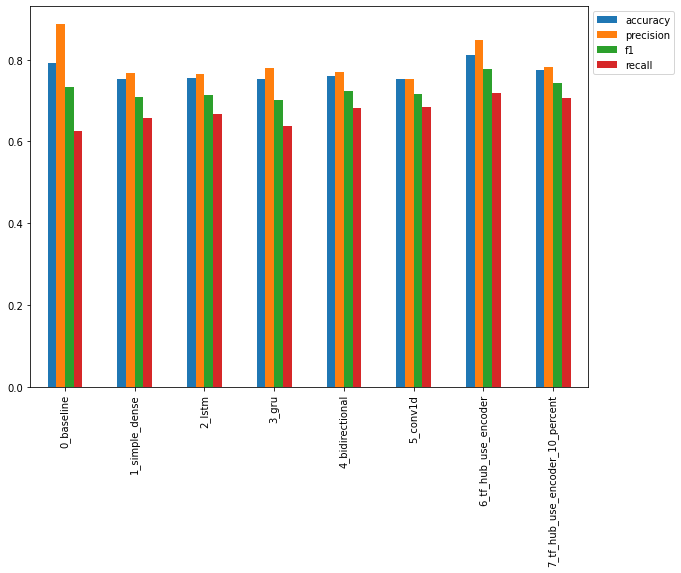

In [106]:
# Plot and compare all of the model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

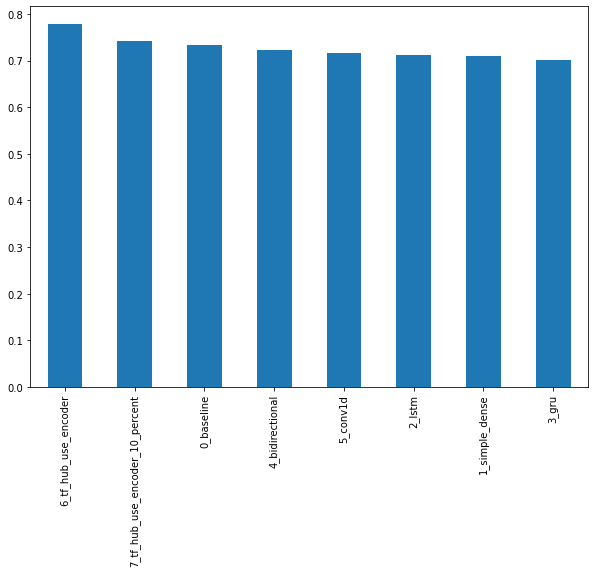

In [107]:
# Sort model results by f1-score
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7));

## Uploading our model training logs to TensorBoard.dev

We can further inspect our model's performance using TensorBoard.dev: https://tensorboard.dev/

In [ ]:
# View TensorBoard logs of transfer learning modelling experiments (plus all of our other models)
# Upload TensorBoard dev records
#!tensorboard dev upload --logdir ./model_logs/ \
#  --name "NLP Modelling Experiments ZTM TF Course" \
#  --description "Comparing multiple different types of model architectures on the Kaggle Tweets text classification dataset" \
#  --one_shot # exit the uploader once uploading is finished


Now I've ran the cell above, my modelling experiments are visable on TensorBoard.dev: https://tensorboard.dev/experiment/X83IoV1uQA6SZ3xdPmhBlg/

**Resource:** TensorBoard is great for quickly tracking experiments but for larger scale experiment tracking options, check out Weights and Biases: https://wandb.ai/site

In [109]:
! tensorboard dev list

2023-03-10 20:32:57.942818: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-03-10 20:32:57.942932: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-03-10 20:32:57.942950: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
2023-03-10 20:33:00.006885: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to c

In [ ]:
# If you need to delete an experiment from TensorBOard, you can run the following:
# !tensorboard dev delete --experiment_id X83IoV1uQA6SZ3xdPmhBlg

## Saving and loading a trained model

There are two main formats to save a model to in TensorFlow:
1. The HDF5 format
2. The `SavedModel` format (this is the default when using TensorFlow)

In [110]:
model_6_results

{'accuracy': 81.23359580052494,
 'precision': 84.7457627118644,
 'f1': 77.76049766718506,
 'recall': 71.83908045977012}

In [111]:
# Save TF Hub Sentence Encoder model to HDF5 format
model_6.save("model_6.h5")

In [114]:
# Load model with custom Hub Layer (required HDF5 format)
# The custom Hub layer was because we loaded obtained a custom layer from an outside source (check line 79)
import tensorflow_hub as hub
loaded_model_6 = tf.keras.models.load_model("model_6.h5",
                                            custom_objects={"KerasLayer": hub.KerasLayer})

In [115]:
# How does our loaded model perform?
loaded_model_6.evaluate(val_sentences, val_labels)

24/24 [==============================] - 2s 24ms/step - loss: 0.4347 - accuracy: 0.8123


[0.4347401261329651, 0.8123359680175781]

In [117]:
model_6_results

{'accuracy': 81.23359580052494,
 'precision': 84.7457627118644,
 'f1': 77.76049766718506,
 'recall': 71.83908045977012}

In [118]:
# Save TF Hub Sentence Encoder model to SavedModel format (default)
model_6.save("model_6_SavedModel_format")

In [119]:
# Load in a model from the SavedMoel format
# Doesnt need to add custom objects as it saves everything about model in folder
loaded_model_6_SavedModel_format = tf.keras.models.load_model("model_6_SavedModel_format")

In [120]:
# Evaluate model in SavedModel format
loaded_model_6_SavedModel_format.evaluate(val_sentences, val_labels)

24/24 [==============================] - 2s 28ms/step - loss: 0.4347 - accuracy: 0.8123


[0.4347401261329651, 0.8123359680175781]

## Finding the most wrong examples

* If our best model still isn't perfect, what examples is it getting wrong?
* And of these wrong examples which ones is it getting *most* wrong (those wilt prediction probabilities closest to the opposite class)

For example if a sample should have a label of 0 but our model predicts a prediction probability of 0.999 (close to 1) and vice versa.

In [121]:
# Download a pretrained model from Google Storage
!wget https://storage.googleapis.com/ztm_tf_course/08_model_6_USE_feature_extractor.zip
!unzip 08_model_6_USE_feature_extractor.zip

--2023-03-10 21:03:58--  https://storage.googleapis.com/ztm_tf_course/08_model_6_USE_feature_extractor.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.128, 142.250.141.128, 2607:f8b0:4023:c0d::80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 960779165 (916M) [application/zip]
Saving to: ‘08_model_6_USE_feature_extractor.zip’

08_model_6_USE_feat 100%[===================>] 916.27M   146MB/s    in 7.8s    

2023-03-10 21:04:06 (117 MB/s) - ‘08_model_6_USE_feature_extractor.zip’ saved [960779165/960779165]

Archive:  08_model_6_USE_feature_extractor.zip
   creating: 08_model_6_USE_feature_extractor/
   creating: 08_model_6_USE_feature_extractor/assets/
   creating: 08_model_6_USE_feature_extractor/variables/
  inflating: 08_model_6_USE_feature_extractor/variables/variables.data-00000-of-00001  
  inflating: 08_model_6_USE_feature_extractor/variables/varia

In [122]:
# Import previously trained model from Google Storage
model_6_pretrained = tf.keras.models.load_model("08_model_6_USE_feature_extractor")
model_6_pretrained.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 11ms/step - loss: 0.4272 - accuracy: 0.8163


[0.42723119258880615, 0.8162729740142822]

In [123]:
# Make predictions with the loaded model from GS
model_6_pretrained_pred_probs = model_6_pretrained.predict(val_sentences)
model_6_pretrained_preds = tf.squeeze(tf.round(model_6_pretrained_pred_probs))
model_6_pretrained_preds[:10] #these shoud be in label format

24/24 [==============================] - 2s 24ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [126]:
# Create DataFrame with validation sentences, validation labels and best performing model predictions
val_df = pd.DataFrame({"text": val_sentences,
                       "target": val_labels,
                       "pred": model_6_pretrained_preds,
                       "pred_prob": tf.squeeze(model_6_pretrained_pred_probs)})
val_df.head()

,text,target,pred,pred_prob
0,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0,0.0,0.159757
1,FedEx no longer to transport bioterror germs i...,0,1.0,0.747162
2,Gunmen kill four in El Salvador bus attack: Su...,1,1.0,0.988749
3,@camilacabello97 Internally and externally scr...,1,0.0,0.196229
4,Radiation emergency #preparedness starts with ...,1,1.0,0.707808


In [127]:
# Find the wrong predictions and sort by prediction probabilities
most_wrong = val_df[val_df["target"] != val_df["pred"]].sort_values("pred_prob", ascending=False)
most_wrong[:10] # these are false positives

,text,target,pred,pred_prob
31,? High Skies - Burning Buildings ? http://t.co...,0,1.0,0.910196
759,FedEx will no longer transport bioterror patho...,0,1.0,0.876982
628,@noah_anyname That's where the concentration c...,0,1.0,0.852300
209,Ashes 2015: AustraliaÛªs collapse at Trent Br...,0,1.0,0.835455
251,@AshGhebranious civil rights continued in the ...,0,1.0,0.827213
393,@SonofLiberty357 all illuminated by the bright...,0,1.0,0.814816
109,[55436] 1950 LIONEL TRAINS SMOKE LOCOMOTIVES W...,0,1.0,0.810840
49,@madonnamking RSPCA site multiple 7 story high...,0,1.0,0.803122
119,@freefromwolves GodsLove &amp; #thankU brother...,0,1.0,0.766901
344,Air Group is here to the rescue! We have 24/7 ...,0,1.0,0.766625


In [128]:
# Check the false positives (model predicted 1 when should've been 0)
for row in most_wrong[:10].itertuples():
  _, text, target, pred, pred_prob = row
  print(f"Target: {target}, Pred: {pred}, Prob: {pred_prob}")
  print(f"Text:\n{text}\n")
  print("----\n")

Target: 0, Pred: 1.0, Prob: 0.9101957082748413
Text:
? High Skies - Burning Buildings ? http://t.co/uVq41i3Kx2 #nowplaying

----

Target: 0, Pred: 1.0, Prob: 0.8769820332527161
Text:
FedEx will no longer transport bioterror pathogens in wake of anthrax lab mishaps http://t.co/lHpgxc4b8J

----

Target: 0, Pred: 1.0, Prob: 0.8523001670837402
Text:
@noah_anyname That's where the concentration camps and mass murder come in. 
 
EVERY. FUCKING. TIME.

----

Target: 0, Pred: 1.0, Prob: 0.835454523563385
Text:
Ashes 2015: AustraliaÛªs collapse at Trent Bridge among worst in history: England bundled out Australia for 60 ... http://t.co/t5TrhjUAU0

----

Target: 0, Pred: 1.0, Prob: 0.8272131681442261
Text:
@AshGhebranious civil rights continued in the 60s. And what about trans-generational trauma? if anything we should listen to the Americans.

----

Target: 0, Pred: 1.0, Prob: 0.8148159384727478
Text:
@SonofLiberty357 all illuminated by the brightly burning buildings all around the town!

----

## Making predictions on the test dataset

In [130]:
# Making predictions on the test dataset and visualizing them
test_sentences = test_df["text"].to_list()
test_samples = random.sample(test_sentences, 10)
for test_sample in test_samples:
  pred_prob = tf.squeeze(model_6_pretrained.predict([test_sample])) # our model expects a list as input
  pred = tf.round(pred_prob)
  print(f"Pred: {int(pred)}, Prob: {pred_prob}")
  print(f"Text:\n{test_sample}\n")
  print("-----\n")

1/1 [==============================] - 0s 74ms/step
Pred: 0, Prob: 0.14105874300003052
Text:
@Mano_twits @Kolaveriboy avast an avalanche of andals

-----

1/1 [==============================] - 0s 52ms/step
Pred: 1, Prob: 0.8187840580940247
Text:
#Nepal: This house near TIA bleeding intÛªl airline companies dry. | http://t.co/lI8wi1kuMY

-----

1/1 [==============================] - 0s 56ms/step
Pred: 0, Prob: 0.08330750465393066
Text:
@AmyRamponi But theyÛªre not crushed? It doesnÛªt set up some negative self-fulfilling prophecy or negative self-talk? #psychat

-----

1/1 [==============================] - 0s 48ms/step
Pred: 0, Prob: 0.11537609994411469
Text:
?? #Police Gents Dart #Watch Stainless Steel Bracelet and White Dial + Gift Box http://t.co/jM85C2uXQY http://t.co/SRogObPiiv

-----

1/1 [==============================] - 0s 49ms/step
Pred: 1, Prob: 0.7824311852455139
Text:
How does a snowstorm happen? Find the answers here: http://t.co/m75fCLUtF2 #snowstorm

-----

1/1 [===

## The speed/score tradeoff


In [131]:
model_6_results

{'accuracy': 81.23359580052494,
 'precision': 84.7457627118644,
 'f1': 77.76049766718506,
 'recall': 71.83908045977012}

In [132]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 88.6178861788618,
 'f1': 73.4006734006734,
 'recall': 62.643678160919535}

In [133]:
# Let's make a function to measure the time of prediction
import time
def pred_timer(model, samples):
  """
  Times how long a model takes to make predictions on samples.
  """
  start_time = time.perf_counter() # get start time
  model.predict(samples) # make predictions
  end_time = time.perf_counter() # get finish time
  total_time = end_time-start_time # calculates how long predictions took to make
  time_per_pred = total_time/len(samples)
  return total_time, time_per_pred

In [134]:
# Calculate TF Hub Sentence ENcoder time per pred
model_6_total_pred_time, model_6_time_per_pred = pred_timer(model_6_pretrained,
                                                            samples=val_sentences)
model_6_total_pred_time, model_6_time_per_pred

24/24 [==============================] - 1s 27ms/step


(1.3677553460001945, 0.0017949545223099666)

In [135]:
# Calculate our baseline model times per pred
baseline_total_pred_time, baseline_time_per_pred = pred_timer(model_0, val_sentences)
baseline_total_pred_time, baseline_time_per_pred

(0.06587688200033881, 8.64526010503134e-05)

In [137]:
# Get results for pretrained GS model
model_6_pretrained_results = evaluate_metrics(y_true=val_labels, y_preds=model_6_pretrained_preds)
model_6_pretrained_results

{'accuracy': 81.62729658792651,
 'precision': 83.98692810457517,
 'f1': 78.59327217125382,
 'recall': 73.85057471264368}

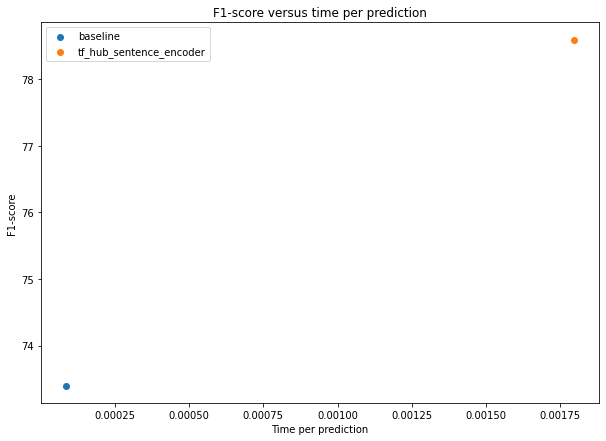

In [138]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plt.scatter(baseline_time_per_pred, baseline_results["f1"], label="baseline")
plt.scatter(model_6_time_per_pred, model_6_pretrained_results["f1"], label="tf_hub_sentence_encoder")
plt.legend()
plt.title("F1-score versus time per prediction")
plt.xlabel("Time per prediction")
plt.ylabel("F1-score");